In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.svm import SVR


from xgboost import XGBRegressor

video link https://www.loom.com/share/c5a4b589c3244e289e9fd01da74a2f24

website link: https://imaliml.herokuapp.com/

In [2]:
df = pd.read_csv("/content/data.csv")
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
# dropping unnecessary columns 
df = df.drop(['Unnamed: 0'],axis=1)

In [4]:
# checking the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Name                      18207 non-null  object 
 2   Age                       18207 non-null  int64  
 3   Photo                     18207 non-null  object 
 4   Nationality               18207 non-null  object 
 5   Flag                      18207 non-null  object 
 6   Overall                   18207 non-null  int64  
 7   Potential                 18207 non-null  int64  
 8   Club                      17966 non-null  object 
 9   Club Logo                 18207 non-null  object 
 10  Value                     18207 non-null  object 
 11  Wage                      18207 non-null  object 
 12  Special                   18207 non-null  int64  
 13  Preferred Foot            18159 non-null  object 
 14  Intern

In [5]:
# checking for missing values
df.isna().sum()

ID                   0
Name                 0
Age                  0
Photo                0
Nationality          0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 88, dtype: int64

In [6]:
# checking the number of missing values
# function to drop columns with more than 50% missing data
def find_missing(data_df):
    columns_dropped = []
    data_missing_df = pd.DataFrame(data_df.isnull().sum(),columns=['no_missing'])
    data_missing_df['percentage_missing'] = (data_missing_df / 594) * 100
    is_greater_than_50 = data_missing_df['percentage_missing']>=50
    is_greater_than_50 = data_missing_df[is_greater_than_50]
    is_greater_than_50.reset_index(inplace=True)
    [columns_dropped.append(i) for i in is_greater_than_50['index']]
    if len(columns_dropped) > 0: 
        return columns_dropped
    else:
        print('no column has more than 50% missing data')

# function to drop our columns with more thn 50%
def drop_missing(data_df):
    data_df.drop(find_missing(data_df),axis=1,inplace = True)
    return data_df

In [7]:
df = drop_missing(df)
# filling the remaining missing alues with their mean
df.fillna(df.mean(),inplace=True)


In [8]:
df.head(500)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,2021,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,2022,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,2022,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,2020,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,2023,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,190778,J. Zoet,27,https://cdn.sofifa.org/players/4/19/190778.png,Netherlands,https://cdn.sofifa.org/flags/34.png,80,83,PSV,https://cdn.sofifa.org/teams/2/light/247.png,€12.5M,€16K,1291,Right,2.0,4.0,1.0,Medium/ Medium,Normal,No,GK,13.0,2021,6'2,194lbs,17.0,12.0,19.0,37.0,19.0,15.0,13.0,20.0,38.0,34.0,57.0,45.0,54.0,77.0,42.0,25.0,57.0,40.0,65.0,17.0,18.0,21.0,11.0,57.0,27.0,61.0,25.0,18.0,16.0,79.0,77.0,77.0,79.0,83.0
496,190544,A. Ljajić,26,https://cdn.sofifa.org/players/4/19/190544.png,Serbia,https://cdn.sofifa.org/flags/51.png,80,81,Beşiktaş JK,https://cdn.sofifa.org/teams/2/light/327.png,€17.5M,€52K,1933,Right,2.0,4.0,4.0,High/ Low,Lean,No,CAM,22.0,"Jun 30, 2019",6'0,163lbs,72.0,69.0,48.0,78.0,74.0,87.0,80.0,83.0,71.0,86.0,82.0,76.0,81.0,74.0,79.0,76.0,63.0,60.0,58.0,78.0,44.0,32.0,75.0,78.0,75.0,75.0,39.0,35.0,35.0,6.0,14.0,7.0,6.0,12.0
497,190286,Canales,27,https://cdn.sofifa.org/players/4/19/190286.png,Spain,https://cdn.sofifa.org/flags/45.png,80,80,Real Betis,https://cdn.sofifa.org

In [9]:
# making preffered foot and bodytype categorical so that they can be converted into numerical
df[["Preferred Foot","Body Type"]] = df[["Preferred Foot","Body Type"]].astype('category')
df.dtypes

ID                             int64
Name                          object
Age                            int64
Photo                         object
Nationality                   object
Flag                          object
Overall                        int64
Potential                      int64
Club                          object
Club Logo                     object
Value                         object
Wage                          object
Special                        int64
Preferred Foot              category
International Reputation     float64
Weak Foot                    float64
Skill Moves                  float64
Work Rate                     object
Body Type                   category
Real Face                     object
Position                      object
Jersey Number                float64
Contract Valid Until          object
Height                        object
Weight                        object
Crossing                     float64
Finishing                    float64
H

In [10]:
# making the preferred foot numerical
df["Body Type"] = df["Body Type"].cat.codes
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,4,Yes,RF,10.0,2021,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,1,Yes,ST,7.0,2022,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,5,Yes,LW,10.0,2022,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,3,Yes,GK,1.0,2020,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,6,Yes,RCM,7.0,2023,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [11]:
# making body type numerical
df["Preferred Foot"] = df["Preferred Foot"].cat.codes
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Contract Valid Until,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,0,5.0,4.0,4.0,Medium/ Medium,4,Yes,RF,10.0,2021,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,1,5.0,4.0,5.0,High/ Low,1,Yes,ST,7.0,2022,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,1,5.0,5.0,5.0,High/ Medium,5,Yes,LW,10.0,2022,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,1,4.0,3.0,1.0,Medium/ Medium,3,Yes,GK,1.0,2020,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,1,4.0,5.0,4.0,High/ High,6,Yes,RCM,7.0,2023,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [12]:
# Dropping lbs from the weight
def weight(number):
  if isinstance(number,str):
    return(number.replace('lbs',''))
  return number
df['Weight'] = df['Weight'].apply(weight).astype('float')

In [13]:
#handling the non numerical data by using encoding techniques
# iterate through the columns
def Nandata(df):
    columns = df.columns.values
    for column in columns:
      # conveerting the columns to alist of it's values and obtain unique values from the set
        mixedvals = {}
        def intconversion(val):
            return mixedvals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_values= df[column].values.tolist()
            unique_values = set(column_values)
            z= 0
            for i in unique_values:
                if i not in mixedvals:
                    mixedvals[i] = z
                    z+=1

            df[column] = list(map(intconversion, df[column]))

    return df

df = Nandata(df)
print(df.head())

       ID   Name  Age  Photo  ...  GKHandling  GKKicking  GKPositioning  GKReflexes
0  158023  15337   31   7490  ...        11.0       15.0           14.0         8.0
1   20801  13665   33  13488  ...        11.0       15.0           14.0        11.0
2  190871  15560   26  16291  ...         9.0       15.0           15.0        11.0
3  193080     24   27  17275  ...        85.0       87.0           88.0        94.0
4  192985  14687   27  17085  ...        13.0        5.0           10.0        13.0

[5 rows x 59 columns]


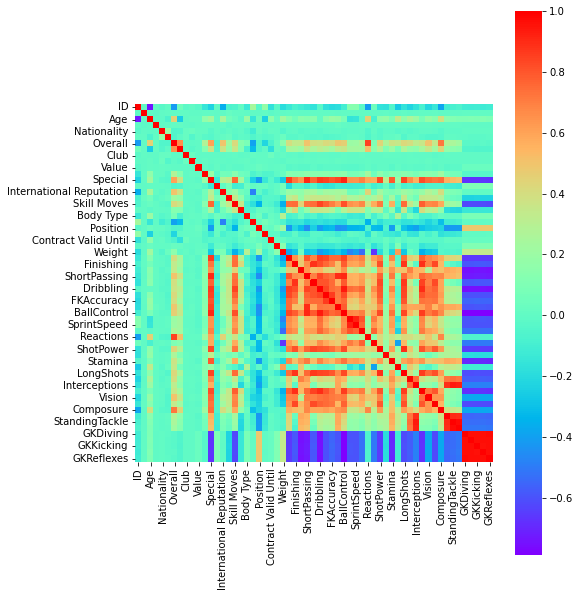

In [15]:
#checking for correlation
corr = df.corr()
plt.figure(figsize=(8, 10))
sns.heatmap(corr, square=True, annot=False, cmap='rainbow')

Text(0, 0.5, 'Columns')

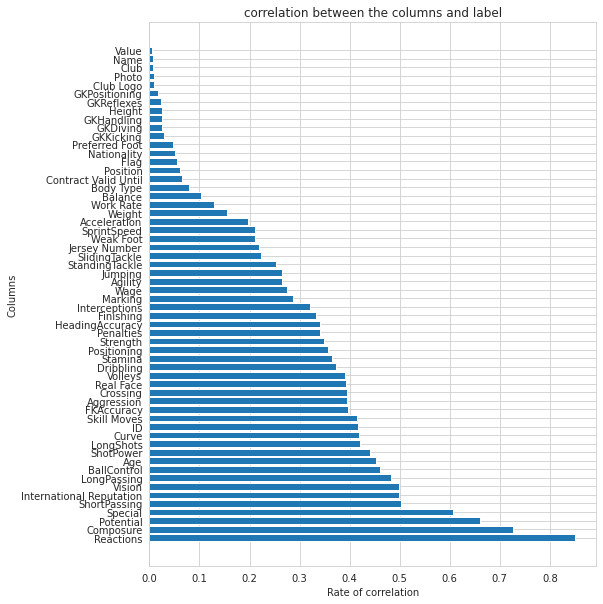

In [16]:
#checking how columns correlate with the label
labelCorr = abs(corr['Overall']).sort_values(ascending=False).drop(['Overall'], axis=0)
sns.set_style("whitegrid")
plt.figure(figsize=(8, 10))
plt.title("correlation between the columns and label")
plt.barh(labelCorr.index, labelCorr)
plt.xlabel("Rate of correlation")
plt.ylabel("Columns")

In [17]:
# printing out the features with more than 0.5 correlation
f_correlation= df.corr()
correlation_target = abs(f_correlation["Overall"])
features_strong = correlation_target[correlation_target>=0.5]
features_strong

Overall         1.000000
Potential       0.660939
Special         0.606960
ShortPassing    0.502300
Reactions       0.849622
Composure       0.727293
Name: Overall, dtype: float64

In [18]:
x = df[['Reactions','Composure','Potential','Wage','Special','ShortPassing','International Reputation','Vision','LongPassing']]
y = df['Overall']

In [19]:
# # splitting our data into train and test data
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.2)

In [20]:
# data scaling and normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [21]:
from sklearn.ensemble import RandomForestRegressor
check_params= RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('The Parameters that are currently in use include:\n')
pprint(check_params.get_params())

The Parameters that are currently in use include:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [22]:
from sklearn.model_selection import RandomizedSearchCV
max_features = ['auto', 'sqrt'] #features that are considered while splitting
n_estimators = [int(i) for i in np.linspace(start = 200, stop = 2000, num = 10)] #no of trees in grid
max_depth = [int(i) for i in np.linspace(10, 110, num = 11)]#shows max number of levels in atree
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]# samples for training each tree are collected
# Creation of the random grid
r_grid = {'max_features': max_features,'n_estimators': n_estimators,'max_depth': max_depth,'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
pprint(r_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [23]:
# We are using the random grid search(r_grid) to look for the best parameters
# We need to create a base for tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
b_model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
b_model = RandomizedSearchCV(estimator = b_model, param_distributions = r_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
b_model.fit(x, y)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.0min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [24]:
b_model.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [25]:
def m_evaluation(model, x, y):
    model_predictions = model.predict(x)
    model_errors = abs(model_predictions - y)
    mape = 100 * np.mean(model_errors / y)
    model_accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(model_errors)))
    print('Accuracy = {:0.2f}%.'.format(model_accuracy))
    return model_accuracy
bs_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
bs_model.fit(x, y)
base_accuracy = m_evaluation(bs_model, x, y)
best_random = b_model.best_estimator_
r_accuracy = m_evaluation(best_random, x, y)
print('Improvement of {:0.2f}%.'.format( 100 * (r_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.6239 degrees.
Accuracy = 99.02%.
Model Performance
Average Error: 0.5122 degrees.
Accuracy = 99.20%.
Improvement of 0.17%.


In [26]:
from sklearn.ensemble import RandomForestRegressor
r_regressor = RandomForestRegressor(n_estimators=20, random_state=0)
r_regressor.fit(x_train, y_train)
y_pred = r_regressor.predict(x_test)

In [27]:
# evaluation of  random regressor model using performance metrics
from sklearn import metrics
print(' The Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('The Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('The Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

 The Mean Absolute Error: 1.5798050521691378
The Mean Squared Error: 4.842475974739155
The Root Mean Squared Error: 2.200562649582864


The feature : 0, Has a score of: is 0.68146
The feature : 1, Has a score of: is 0.03725
The feature : 2, Has a score of: is 0.11823
The feature : 3, Has a score of: is 0.04037
The feature : 4, Has a score of: is 0.06433
The feature : 5, Has a score of: is 0.01572
The feature : 6, Has a score of: is 0.00636
The feature : 7, Has a score of: is 0.02171
The feature : 8, Has a score of: is 0.01457


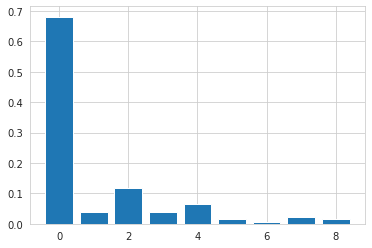

In [28]:
# looking for fetaure importance
from matplotlib import pyplot
importance = r_regressor.feature_importances_
# summarize feature importance
for i,j in enumerate(importance):
	print('The feature : %0d, Has a score of: is %.5f' % (i,j))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [29]:
accuracy = r_regressor.score(x_test,y_test)
print(accuracy)


0.8987888464879974


In [32]:
import xgboost
print(xgboost.__version__)

0.90


In [33]:
# fine tune 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
dmatrix = xgb.DMatrix(data=x, label=y)
params={ 'objective':'reg:squarederror',
         'max_depth': 6, 
         'colsample_bylevel':0.5,
         'learning_rate':0.01,
         'random_state':20}
cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20, num_boost_round=1000)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 2.04


In [34]:
# using xgboost regression
model_xgb = XGBRegressor()
model_xgb.fit(x_train,y_train)

[13:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Feature: 0, Score: 0.52027
Feature: 1, Score: 0.17519
Feature: 2, Score: 0.08157
Feature: 3, Score: 0.07272
Feature: 4, Score: 0.03447
Feature: 5, Score: 0.02084
Feature: 6, Score: 0.08390
Feature: 7, Score: 0.00739
Feature: 8, Score: 0.00365


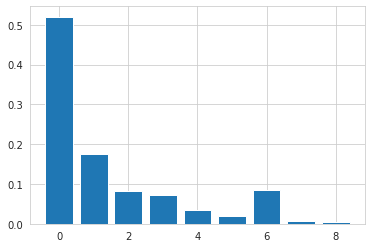

In [35]:
from matplotlib import pyplot
importance = model_xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [36]:
# train our model and check for accuracy
# model_xgb.fit(x_train, y_train)
accuracy = model_xgb.score(x_test,y_test)
print(accuracy)




0.8952700334770884


In [54]:
model_xgb.fit(x_train,y_train)

preds = model_xgb.predict(x_test)

[14:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
# in comparisson with the random forest xgboost has a higher RMSE 
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2.238489


In [38]:
with open('model_xgb.pkl', 'wb') as model_file:
  pickle.dump(model_xgb, model_file)

In [39]:
# load model from file
file_name = 'model_xgb.pkl'
loaded_model = pickle.load(open(file_name, "rb"))

[13:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
with open('r_regressor.pkl', 'wb') as model_file:
  pickle.dump(r_regressor, model_file)

In [41]:
# load model from file
file_name = 'r_regressor.pkl'
loaded_model = pickle.load(open(file_name, "rb"))